In [3]:

import os
import tensorflow as tf
# Loada dei modelli compressi da tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [5]:
# classe con utils functions
class Utils():

  #trasforma un tensore in un oggetto immagine (Pil.Image)
  def tensor_to_image(self,tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
  # ritorna un oggetto immagine caricato da un path datogli, setta la massima dimensione a 512
  def load_img(self,path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img
  # printa a schermo l'immagine datagli
  def imshow(self,image, title=None):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    
    if title:
      plt.title(title)
  def clip_0_1(self,image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
class ModelStructure(tf.keras.models.Model):
  def __init__(self,util):
    super(ModelStructure, self).__init__()
    # questi parametri sono settati di default con l'inizializzazione del costruttore
    # possono essere modificati duranti il training
    self.util = util
    self.content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
    self.style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
    self.training_image_path= "/content/gdrive/MyDrive/immagine_paper.jpg"
    self.vgg = None
    self.vgg =  self.vgg_layers(['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1','block5_conv2'])
    self.style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
    self.content_layers = ['block5_conv2']
    self.num_style_layers = len(self.style_layers)
    self.num_content_layers = len(self.content_layers)
    self.opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    self.content_image = tf.Variable(util.load_img(self.content_path))
    self.style_image = tf.Variable(util.load_img(self.style_path))
    self.image = self.content_image
    self.style_weight=1e-2
    self.content_weight=1e4
    self.total_variation_weight=50
    

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
  def printVggLayers(self):
    for layer in self.vgg.layers:
      print(layer.name)

  def set_content_image(self,image_path):
    self.content_path = image_path
    self.content_image = tf.Variable(self.util.load_img(image_path))
  def set_style_image(self,image_path):
    self.style_path = image_path
    self.style_image = tf.Variable(self.util.load_img(image_path))
  def set_training_image(self,image_path):
    self.training_image_path=image_path
    self.image = tf.Variable(self.util.load_img(image_path))
  #ritorna un modello rispetto agli output dati in layer names
  def vgg_layers(self,layer_names):
    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')# carica vgg senza i fully connected layers finali (vgg usata per la classification)
    self.vgg.trainable = False
    outputs = [self.vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([self.vgg.input], outputs)
    return model
  
  def set_loss_weights(self,style_weight, content_weight, variation_weight):
    self.style_weight = style_weight
    self.content_weight = content_weight
    self.total_variation_weight=variation_weight

  def set_vgg_layers(self,style_layers, content_layers):
    self.vgg_layers(style_layers+content_layers)
  
  def set_optimizer(self,optimizer,learning_rate,momentum,beta_1, beta_2, initial_accumulator_value, epsilon, rho):
    if optimizer == 'ADAM':
      self.opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2, epsilon=epsilon)
    elif optimizer == 'ADAGRAD':
      self.opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=initial_accumulator_value,epsilon=epsilon)
    elif optimizer == 'RMSPROP':
      self.opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=rho, momentum=momentum, epsilon=epsilon)
    elif optimizer == 'ADADELTA':
      self.opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)
    elif optimizer == 'ADAMAX':
      self.opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

  # computa la gram matrix per lo style error
  def gram_matrix(self,input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
  
  def style_content_loss(self,outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    return loss 

In [8]:
@tf.function()
def train_step(model,image, style, content):
  with tf.GradientTape() as tape:
    outputs = model(image)
    loss = model.style_content_loss(outputs,style,content)
    loss += model.total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  model.opt.apply_gradients([(grad, image)])
  image.assign(util.clip_0_1(image))

In [9]:
def model_training_and_output(epochs, steps_per_epoch, model):
  step = 0
  image = tf.Variable(model.util.load_img(model.training_image_path))
  model.set_content_image(model.content_path)
  model.set_style_image(model.style_path)
  style = model(model.style_image)['style']
  content = model(model.content_image)['content']
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      
      train_step(model,image, style,content)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(model.util.tensor_to_image(image))
    print("Train step: {}".format(step))

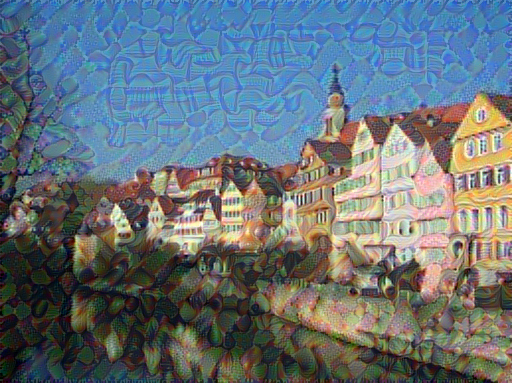

Train step: 40
.......

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 10
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 10 
  content_weight = 10
  variational_weight = 10
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  #c'è anche per il content image

  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  



  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY CHOOSING THE SAME PARAMETERS OF THE PAPER
Content/Style weight= 10^(-5); Total Variation weight= 0; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fourth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [10]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 10
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 0
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  #c'è anche per il content image
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block4_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)
  
  model_training_and_output(epochs,steps_per_epoch,model)

InvalidArgumentError: ignored

#NEW TRY WITH A LEARNING RATE GREATER (0.1)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.1 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.1
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
 

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH LEARNING RATE LOWER (0.001)
Content/Style weight= 10^(-5); Total Variation weight= 0; Learning rate = 0.001 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.001
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT CONTENT/STYLE WEIGHT (10^-4)
Content/Style weight= 10^(-4); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 20000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)



  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT CONTENT/STYLE WEIGHT (10^-3)
Content/Style weight= 10^(-3); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  

  # per cambiare i pesi delle loss posso fare
  style_weight = 2000
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  model_training_and_output(epochs,steps_per_epoch,model)

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)




  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT CONTENT/STYLE WEIGHT (10^-2)
Content/Style weight= 10^(-2); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
 
  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)




  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT CONTENT/STYLE WEIGHT (10^-1)
Content/Style weight= 10^(-1); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 20
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
 

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT TOTAL VARIATION WEIGHT (1000)
Content/Style weight= 10^(-5); Total Variation weight= 1000; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 1000
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)



  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT TOTAL VARIATION WEIGHT (10^-1)
Content/Style weight= 10^(-5); Total Variation weight= 10^(-1); Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100



In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 0.1
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)

  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH DIFFERENT STYLE LAYERS (FIRST 4)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of 4 of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)


  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH DIFFERENT STYLE LAYERS (FIRST 3)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of 3 of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [10]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH DIFFERENT STYLE LAYERS (LAST 4)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of the last 4 of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [11]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)

  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A GREATER NUMBER OF EPOCHS (20)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 20; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 20
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)


  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)



  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A GREATER NUMBER OF EPOCHS (30)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 30; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 30
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT OPTIMIZER (ADAM)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAM optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAM'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
 

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT OPTIMIZER (RMSPROP)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (RMSPROP optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'RMSPROP'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 30
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  
  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT OPTIMIZER (ADADELTA)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADADELTA optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADADELTA'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 30
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)


  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)



  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A DIFFERENT OPTIMIZER (ADAMAX)
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAMAX optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAMAX'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 30
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  content_path = "/content/gdrive/MyDrive/immagine_paper.jpg"
  model.set_content_image(content_path)
  model.set_training_image(content_path)

  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

# NEW TRY WITH A WHITE NOISE IMAGE
Content/Style weight= 10^(-5); Total Variation weight= 50; Learning rate = 0.01 (ADAGRAD optimizer); Content Layer= Fifth Layer, Second Block; Style Layers= First Block of each of the 5 Layers; Epochs= 10; Steps per Epoch= 100

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)


  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  model.set_content_image(tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'))

  #upload white noise image
  
  training_image_path="/content/gdrive/MyDrive/rumore_bianco.jpg"
  model.set_training_image(training_image_path)
  #model.set_training_image(tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'))
  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)


  model_training_and_output(epochs,steps_per_epoch,model)

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  #model_training_and_output(10,100,model)

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
  optimizer = 'ADAGRAD'
  lr = 0.01
  momentum = 0.9
  BETA1 = 0.9
  BETA2 = 0.9
  initial_accumulator_value = 0.01
  epsilon = 1e-7
  rho = 0.95
  epochs = 10
  steps_per_epoch = 100
  model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # per cambiare i pesi delle loss posso fare
  style_weight = 200000 
  content_weight = 2
  variational_weight = 50
  model.set_loss_weights(style_weight,content_weight,variational_weight)
  #model_training_and_output(epochs,steps_per_epoch,model)

  # posso cambiare le immagini
  model.set_style_image(tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'))
  model.set_content_image(tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'))

 
  model.set_training_image(training_image_path)
  model.set_training_image(tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'))
  #posso anche cambiare i layers
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
  model.set_vgg_layers(style_layers, content_layers)



  model_training_and_output(epochs,steps_per_epoch,model)